# Receiver Function inversion: optimization and Bayesian sampling

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/receiver_function/receiver_function_no_espresso.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In this notebook, we run inversion on a receiver function inversion problem with optimisation and sampling.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi pyrf96

In [2]:
# If this notebook is run locally pyrf96 needs to be installed separately by uncommenting the following lines, 
# that is by removing the # and the white space between it and the exclamation mark.
# !pip install pyrf96

In [3]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import arviz
import emcee
import multiprocessing

import cofi
import pyrf96

In [4]:
# randomness is used to initialise emcee walkers starting points
np.random.seed(42)

In [5]:
# display theory on receiver function
from IPython.display import display, Markdown

with open("../../theory/geo_receiver_function.md", "r") as f:
    content = f.read()

display(Markdown(content))

Receiver functions are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

We refer you to the paper below for description of the algorithms and the forward kernel we use:

*Genetic algorithm inversion for receiver functions with application to crust and uppermost mantle structure beneath Eastern Australia*,
Shibutani, T., Kennett, B. and Sambridge, M., Geophys. Res. Lett., 23 , No. 4, 1829-1832, 1996.

In order to better understand the complexity and non-linear nature of seismic receiver function inversion, we have included a few illustrative animations. These animations highlight the substantial influence of velocities and, more prominently, interface depths on the resulting receiver functions.

![depth_layer3_anim4.gif](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/depth_layer3_anim4.gif?raw=true)

![vel_layer3_anim4_400f.gif](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/vel_layer3_anim4_400f.gif?raw=true)

This is a non-linear problem which can be highly sensitive to the starting model. 

![3Dsurf_x40y10_v55_l270_35](https://github.com/inlab-geo/cofi-examples/blob/main/theory/illustrations/3Dsurf_x40y10_v55_l270_35.png?raw=true)


We are going to use the receiver function package in 
[`pyrf96`](https://github.com/inlab-geo/pyrf96),
with calls to Fortran routines developed by Prof. T. Shibutani in the backend.

The function `pyrf96.rfcalc()` computes synthetic receiver functions (using routines developed by Prof. T. Shibutani). It is called as follows:
```python
t,rfunc = pyrf96.rfcalc(model)
```
where `model` is a NumPy array of dimension `[nlayers,3]`. 

#### Model formats
Three input model formats are possible depending on optional parameter `mtype`.


**Voronoi cell mode** (`mtype=0`, default):
In this case `model[:,0]` are the depths of Voronoi cell nuclei, which each define a layer of constant velocity. Here interfaces are defined implicitely as the mid-points between successive nuclei. For example, the interface at the base of the first layer lies at depth `0.5*[model[0,0]+model(1,0)]`
The S-wave speeds for each layer are given by  `model[:,1]`, and `model[:,2]` are the ratio of P-wave speed to S-wave speed in each layer. This format is convenient as a parameterization for optimization, or Bayesian sampling, since nuclei are independent and can be unordered. See Figure 1 of [Bodin et al. 2012](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011JB008560).

**Layer thickness mode** (`mtype=1`):
In this case  `model[:,0]` are the thicknesses of each layer. Here interfaces are defined implicitely as the sum of successive thicknesses. For example, the interface at the base of the second layer lies at depth `model[0,0]+model(1,0)`. The S-wave speeds for each layer are given by  `model[:,1]`, and `model[:,2]` are the ratio of P-wave speed to S-wave speed in each layer.

**Interface depth mode** (`mtype=2`):
In this case the values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of P-wave speed to S-wave speed. The maximum depth of discontinuity that can be considered is 60km.

For full details see the docstring `help(pyrf96.rfcalc)` 

For example, here is the Earth model in interface depth mode (`mtype=0`).

In [6]:
good_model = np.array([[1,3.0,1.7],
                  [8.0,3.2,2.0],
                  [20, 4.0,1.7],
                  [45,4.2,1.7]])

Consider a model setup of `n` layers described with 3 parameters for each layer. `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.
In this example, we fix the ratio of S-wave speed to P-wave speed, and treat the interface depths and velocities of 3 layers as unknowns.

Here we use the model to calculate the receiver function both with and without correlated noise added, with signal to noise parameter `sn=0.5`. (The noise here is added in the frequency domain, for details see Shibutani etal. (1996).)

In [7]:
# calculate and plot receiver function
t,rfunc = pyrf96.rfcalc(good_model)          # Receiver function
t2,rfunc_noise = pyrf96.rfcalc(good_model,sn=0.5,seed=12345678) # Receiver function with added correlated noise

If we had field data we wanted to invert we would load here and simply assign it to `t2` and `rfunc_noise` that is replace our synthetic data.

Now we plot the model and the receiver function together.

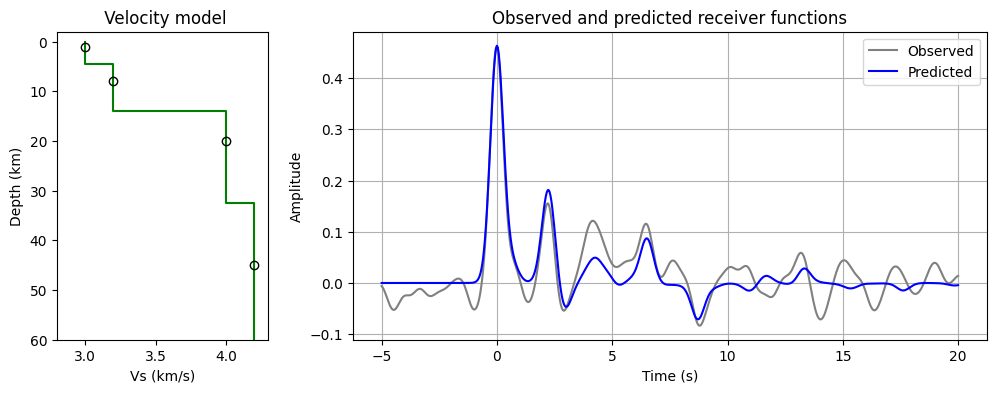

In [8]:
# plot RF together with noise 
a,b = pyrf96.plotRFm(good_model,t2,rfunc_noise,t,rfunc,
    vmin=2.8,
    vmax=4.3,
    dmin=-2.0,
    dmax=60.0,
    plotnuclei=True,
    title="Observed and predicted receiver functions")

## 1. Solve with an optimiser

### 1.1 Problem set up

Here we decide to only vary the layer velocities and interface depths only, and not the Vp/Vs ratio parameters in the Earth model. So we have to provide a subset of the model vector to the minimization routine. We define a simple conversion between the two with routines `get_inversion_parameters()` and its converse `get_model_parameters()`.

In [9]:
# conversion routines
vpvs = good_model[:,2] # fixed vpvs parameters
def get_inversion_parameters(fullmodel): # convert model to inversion parameters
    return fullmodel[:,:2].flatten() # remove last column and flatten
#
def get_model_parameters(invmodel): # convert inversion parameters to fullmodel
    return np.append(invmodel.reshape(len(vpvs),-1), vpvs[:,None],axis=1) # reshape and add last column

In preparation for optimisation we need to measure the fit of this *observed* receiver function to the receiver function predicted by any other model, ${\mathbf d}_{pred}$, we need to compute the negative log of the Likelihood

\begin{equation*}
-\log (p({\mathbf d}_{obs} | {\mathbf m}) = ({\mathbf d}_{obs}-{\mathbf d}_{pred})^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred})
\end{equation*}

where $C_D^{-1}$ is the inverse data covariance matrix describing correlated noise in the receiver function. You can do this using the supplied routine `rfcalc.InvDataCov` which takes arguments ($\sigma_t$,$\sigma_a$,$n$), and builds an $n\times n$ inverse data covariance matrix for a time signal with amplitude variance $\sigma_a^2$ and time correlation length $\sigma_t$, for receiver length of $n$ time samples. In this example you can use $\sigma_t = 2.5$, $\sigma_a=0.01$. 

In [10]:
observed_data = rfunc_noise                    # Define observed data
Cdinv = pyrf96.InvDataCov(2.5,0.01,len(rfunc)) # Define inverse data covaraince for the noisy receiver function

In [11]:
def my_misfit(imodel): # misfit function to be minimized
    model = get_model_parameters(imodel)       # recover full model from inversion parameters
    t,predicted_data = pyrf96.rfcalc(model)    # predicted data from model
    res = observed_data-predicted_data         # residual between observed and predicted data
    misfit_val = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0 # data misfit
    if math.isnan(misfit_val):
        return float("inf")
    return misfit_val

### 1.1 Define BaseProblem

In [12]:
my_problem = cofi.BaseProblem()

Here we set a starting model that is reasonably close to the true model, so that the optimisation converges.

In [13]:
initialmodel = np.array([[1.1,3.0,1.7],
                  [7.0,3.2,2.0],
                  [18, 4.1,1.7],
                  [40,4.2,1.7]])

In [14]:
# problem set up in cofi
my_problem.set_objective(my_misfit)
my_problem.set_initial_model(get_inversion_parameters(initialmodel))

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: (8,)
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
-- none --
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'blobs_dtype', 'bounds', 'constraints']


### 1.2 Define InversionOptions

In [15]:
my_options_optimiser = cofi.InversionOptions()
my_options_optimiser.set_tool("scipy.optimize.minimize")
my_options_optimiser.set_params(method="Nelder-Mead")   # Nelder-Mead or COBYLA

### 1.3 Define Inversion and run

In [16]:
inv_optimiser = cofi.Inversion(my_problem, my_options_optimiser)
my_result_optimiser = inv_optimiser.run()
my_result_optimiser.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 419.71864731069707
nit: 398
nfev: 726
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[ 0.87382911,  3.00712078,  7.82031748,  3.096053  , 19.6149401 ,
         3.93567792, 40.04406483,  4.38054516],
       [ 0.87382911,  3.00712078,  7.82031748,  3.096053  , 19.6149401 ,
         3.93567792, 40.04406484,  4.38054516],
       [ 0.87382911,  3.00712079,  7.82031749,  3.096053  , 19.61494009,
         3.93567792, 40.04406486,  4.38054516],
       [ 0.87382911,  3.00712079,  7.82031749,  3.096053  , 19.61494009,
         3.93567792, 40.04406486,  4.38054516],
       [ 0.87382911,  3.00712079,  7.8203175 ,  3.09605301, 19.6149401 ,
         3.93567792, 40.04406489,  4.38054516],
       [ 0.8738291 ,  3.00712079,  7.8203175 ,  3.09605301, 19.61494009,
         3.93567792, 40.04406488,  4.38054516],
       [ 0.8738291 ,  3.00712079,  7.8203175 ,  3.09605301, 19.61494009,
         3.93567792

In [17]:
my_result_model = get_model_parameters(my_result_optimiser.model)
print("Inversion result:    \n", my_result_model)
print("Reference good model:\n", good_model)

Inversion result:    
 [[ 0.87382911  3.00712078  1.7       ]
 [ 7.82031748  3.096053    2.        ]
 [19.6149401   3.93567792  1.7       ]
 [40.04406483  4.38054516  1.7       ]]
Reference good model:
 [[ 1.   3.   1.7]
 [ 8.   3.2  2. ]
 [20.   4.   1.7]
 [45.   4.2  1.7]]


### 1.4 Plotting

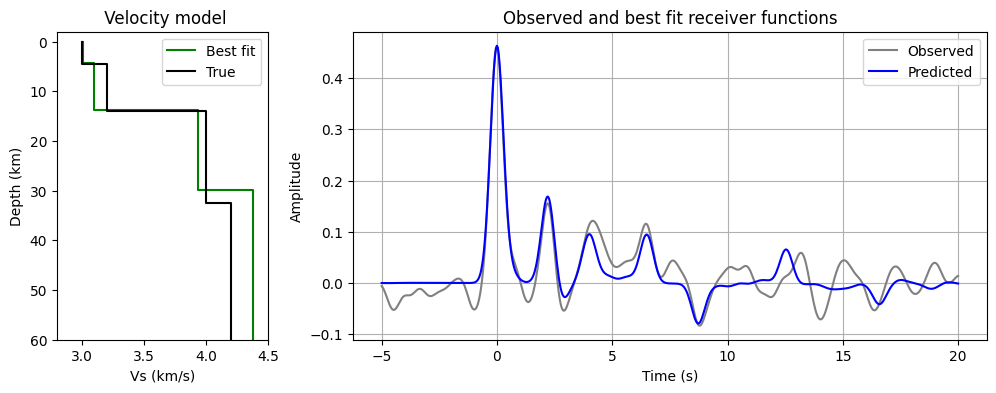

In [18]:
t,predicted_data = pyrf96.rfcalc(my_result_model)    # predicted data from model
a,b = pyrf96.plotRFm(my_result_model,t,observed_data,t,predicted_data,
    vmin=2.8,
    vmax=4.5,
    dmin=-2.0,
    dmax=60.0,
    title="Observed and best fit receiver functions",
    velmod2=good_model,
    plotnuclei = False,
    modlabels=['Best fit','True'])

## 2. Bayesian sampling

### 2.1 Enrich BaseProblem

In preparation for sampling:

In [19]:
def my_log_likelihood(model): # log-likelihood of negative of our misfit
    return -my_misfit(model)

def my_log_prior(model): # define a uniform prior between bounds on interface depths and S-velocity

    real_model = get_model_parameters(model) # recover full model from inversion parameters 
    depths_in_0_60 = all([m_p < 60 and m_p > 0 for m_p in good_model[:,0]]) # are all interface depths between 0,60km? 
    veloc_in_range = all([m_p < 4.5 and m_p > 2 for m_p in good_model[:,1]]) # are all velocities depths between 2,4.5km/s?
    if depths_in_0_60 and veloc_in_range: # return log of prior normalization
        return (-np.log(60.)-np.log(2.5)).item()
    return float("-inf")

ndim = len(get_inversion_parameters(good_model))

my_problem.set_model_shape(ndim)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_log_prior(my_log_prior)

my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: 8
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'log_likelihood', 'log_prior', 'initial_model', 'model_shape', 'blobs_dtype']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['log_posterior', 'log_posterior_with_blobs']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'bounds', 'constraints']


In [20]:
nwalkers = 32
nsteps = 25000
walkers_start = my_result_optimiser.model + 1e-1 * np.random.randn(nwalkers, ndim)

We can run `emcee` in parallel. Some additional preparation:

### 2.2 Define InversionOptions, Inversion and run

In [21]:
import warnings
warnings.filterwarnings("ignore")

my_options_sampler = cofi.InversionOptions()
my_options_sampler.set_tool("emcee")
my_options_sampler.set_params(
    nwalkers=nwalkers,
    nsteps=nsteps,
    initial_state=walkers_start,
    progress=True,
)
inv_sampler = cofi.Inversion(my_problem, my_options_sampler)
inv_result_sampler = inv_sampler.run()

100%|████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:21<00:00, 95.78it/s]


In [22]:
inv_result_sampler.summary()

Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### 2.3 Plotting

In [23]:
var_names = [
    "depth1 (km)", 
    "velocity1 (km/s)", 
    "depth2 (km)", 
    "velocity2 (km/s)", 
    "depth3 (km)", 
    "velocity3 (km/s)", 
    "depth4 (km)", 
    "velocity4 (km/s)", 
]
true_model = get_inversion_parameters(good_model)
var_lines = [(var_names[i],{}, true_model[i]) for i in range(len(var_names))]
az_inf_data = inv_result_sampler.to_arviz(var_names=var_names)
az_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

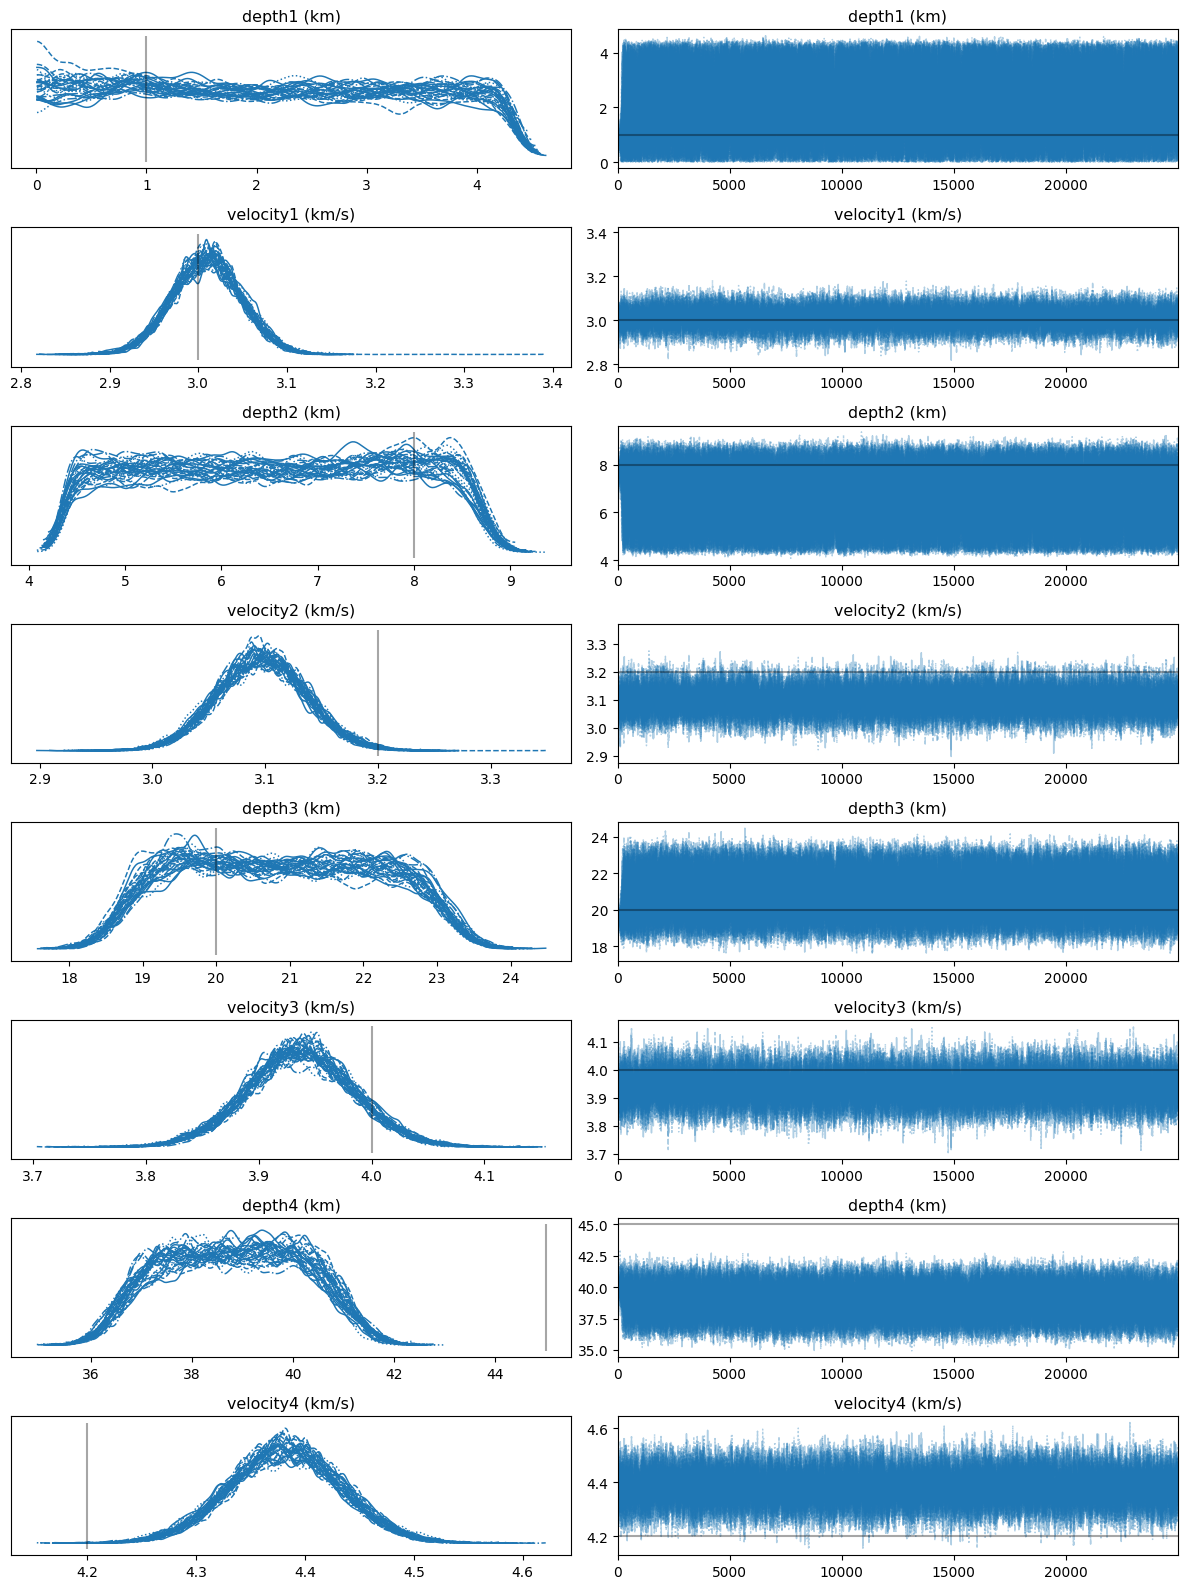

In [24]:
arviz.plot_trace(az_inf_data, var_names=var_names,lines=var_lines);
plt.tight_layout();

The walkers start in small distributions around some chosen values and then they quickly wander and start exploring the full posterior distribution. In fact, after a relatively small number of steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time (see Emcee's package the -[*Autocorrelation analysis & convergence tutorial*](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) for more details). Usually for reliability we want the length of the chains to be greater that fifty times the largest autocorrelation time of any parameter.

In [25]:
tau = inv_result_sampler.sampler.get_autocorr_time()
print(f"autocorrelation times for each parameter:\n {tau}")
tau_ok = all([tcorr < 50*nsteps for tcorr in tau]) # were the chains long enough?
if(tau_ok): 
    print("All autocorrelation times OK")
else:
    print("Autocorrelation unreliable. Increase length of chains and rerun")

autocorrelation times for each parameter:
 [131.36371472 115.55629252 130.22446186 118.13774592 130.43306518
 116.82715614 125.69756058 116.04832188]
All autocorrelation times OK


Let’s discard the initial 500 steps and make a corner plot:

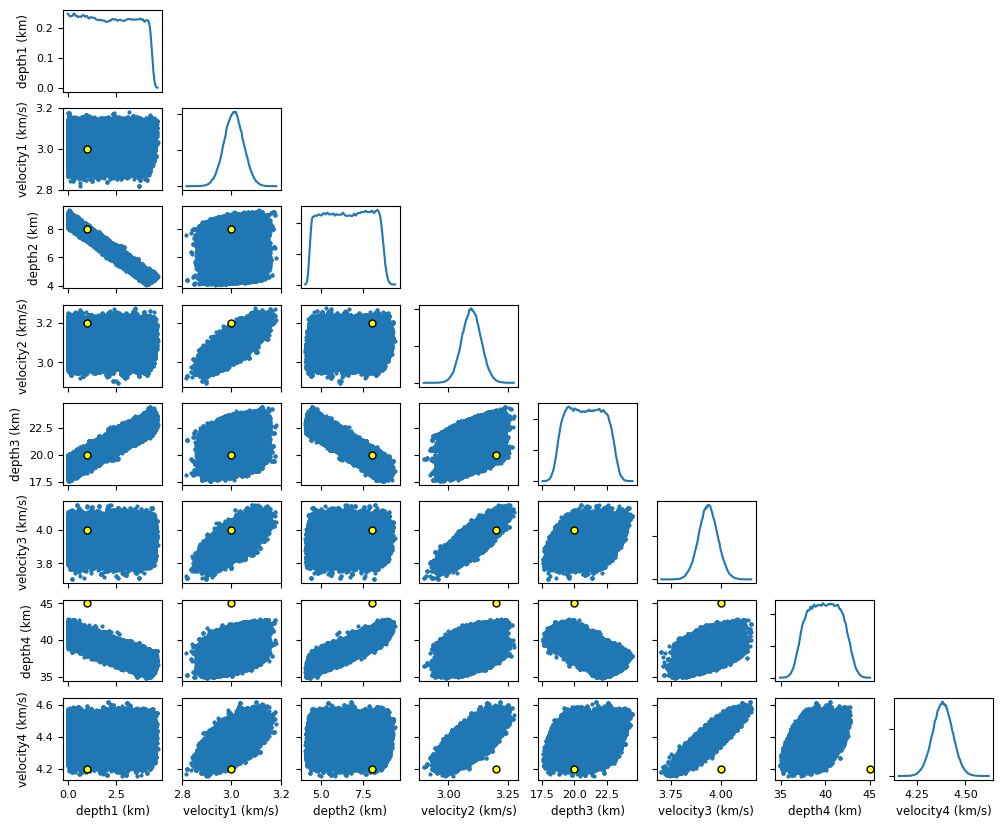

In [26]:
az_inf_data_after_500 = az_inf_data.sel(draw=slice(300,None))

true_values = {
    f"{var_names[i]}": true_model[i] for i in range(true_model.size)
}

fig, axes = plt.subplots(8, 8, figsize=(12, 10))
_ = arviz.plot_pair(
    az_inf_data_after_500,
    marginals=True,
    ax=axes,
    textsize=8,
)

for i, j in np.ndindex(axes.shape):
    if i == j:
        continue
    xlabel = axes[-1, j].get_xlabel()
    ylabel = axes[i, 0].get_ylabel()
    x_true = true_values[xlabel]
    y_true = true_values[ylabel]
    axes[i, j].plot(x_true, y_true, "yellow", marker="o", ms=5, markeredgecolor="k")

plt.show()


Now examine the mean model of the posterior ensemble.

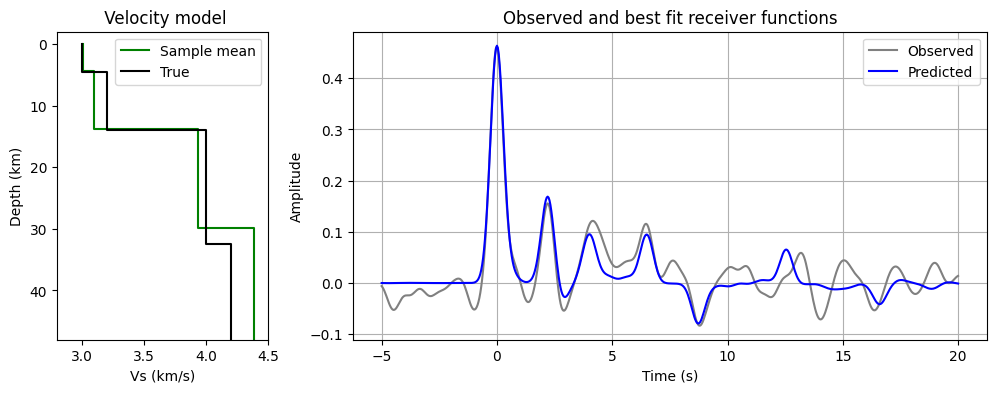

Mean of samples:
      [ 2.1350329   3.00938073  6.56630279  3.09689264 20.88200717  3.93710166
 38.83226869  4.38169858]
Reference good model:
 [ 1.   3.   8.   3.2 20.   4.  45.   4.2]


In [27]:
mean_sample = np.array(az_inf_data["posterior"][var_names].mean().to_array())
median_sample = np.array(az_inf_data["posterior"][var_names].median().to_array())

my_mean_model = get_model_parameters(mean_sample)

t,mean_sample_predicted_rf = pyrf96.rfcalc(my_mean_model)          # Receiver function

a,b = pyrf96.plotRFm(my_mean_model,t,observed_data,t,mean_sample_predicted_rf,
    vmin=2.8, vmax=4.5, dmin=-2.0,dmax=48.0,
    title="Observed and best fit receiver functions",
    velmod2=good_model,modlabels=['Sample mean','True'])

print("Mean of samples:\n     ", mean_sample)
print("Reference good model:\n", true_model)

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [28]:
watermark_list = ["cofi", "numpy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.2.3
matplotlib 3.10.1
emcee 3.1.6
arviz 0.21.0
